<a href="https://colab.research.google.com/github/techoffing/Colour-aqnalysis-theory/blob/main/Biometrics_unimodal_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!ls /content/


 drive	'iris (1).zip'	 sample_data


In [17]:
# Update package list
!apt-get update

# Install the latest version of unzip
!apt-get install -y unzip

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,678 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,763 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,692

In [19]:
!file "/content/iris (1).zip"

/content/iris (1).zip: Zip archive data, at least v4.5 to extract, compression method=deflate


In [20]:
!rm "/content/iris (1).zip"

In [21]:
!ls /content/


 drive	'iris (1).zip'	 sample_data


In [22]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import filters
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from scipy.ndimage import convolve
from scipy.spatial.distance import hamming

In [25]:
zip_path = '/content/iris(1).zip'

In [27]:
import os

zip_path = '/content/iris (1).zip'

# Check if the file exists
if os.path.exists(zip_path):
    print(f"File found at: {zip_path}")
else:
    print(f"File not found at: {zip_path}")

File found at: /content/iris (1).zip


In [28]:
import zipfile

zip_path = '/content/iris (1).zip'

# Check if the file exists
if os.path.exists(zip_path):
    print(f"File found at: {zip_path}")

    # Open the zip file
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print("Zip file opened successfully.")
            # List all files in the zip file
            file_list = zip_ref.namelist()
            print(f"Files in the zip: {file_list}")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file or is corrupted.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File not found at: {zip_path}")

File found at: /content/iris (1).zip
Error: The file is not a valid zip file or is corrupted.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import filters
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from scipy.ndimage import convolve
from scipy.spatial.distance import hamming

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

iris_images = load_images_from_folder('/content/drive/MyDrive/iris_dataset')

In [4]:
def preprocess_image(image):
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Normalize the image
    normalized = cv2.equalizeHist(blurred)
    return normalized

preprocessed_images = [preprocess_image(img) for img in iris_images]

In [5]:
def detect_iris_boundaries(image):
    edges = canny(image, sigma=3)
    hough_radii = np.arange(100, 150, 5)
    hough_res = hough_circle(edges, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)
    return cx[0], cy[0], radii[0]

iris_boundaries = [detect_iris_boundaries(img) for img in preprocessed_images]

In [6]:
def normalize_iris(image, cx, cy, radius):
    # Create a mask for the iris region
    mask = np.zeros_like(image)
    cv2.circle(mask, (cx, cy), radius, 255, -1)
    # Apply the mask
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    # Normalize to a fixed size (e.g., 64x512)
    normalized = cv2.resize(masked_image, (512, 64))
    return normalized

normalized_iris_images = [normalize_iris(img, cx, cy, radius) for img, (cx, cy, radius) in zip(preprocessed_images, iris_boundaries)]

In [8]:
def log_gabor_filter(image, wavelength, orientation):
    # Create a 1D Log-Gabor filter
    radius = np.arange(0, image.shape[1])
    log_gabor = np.exp(-(np.log(radius / wavelength) ** 2 / (2 * np.log(1.5) ** 2)))
    log_gabor[0] = 0  # Set the DC component to zero
    # Apply the filter
    filtered = convolve(image, log_gabor, mode='wrap')
    return filtered

def extract_iris_features(image):
    # Extract features using multiple orientations and wavelengths
    features = []
    for wavelength in [10, 20, 30]:
        for orientation in [0, 45, 90, 135]:
            filtered = log_gabor_filter(image, wavelength, orientation)
            features.append(filtered)
    return np.concatenate(features)

iris_features = [extract_iris_features(img) for img in normalized_iris_images]

In [9]:
def calculate_hamming_distance(template1, template2):
    # Convert templates to binary
    binary1 = template1 > np.mean(template1)
    binary2 = template2 > np.mean(template2)
    # Calculate Hamming distance
    return hamming(binary1.flatten(), binary2.flatten())

def calculate_match_scores(query_features, gallery_features):
    scores = []
    for query in query_features:
        row = []
        for gallery in gallery_features:
            row.append(calculate_hamming_distance(query, gallery))
        scores.append(row)
    return np.array(scores)

match_scores = calculate_match_scores(iris_features, iris_features)

In [10]:
def hamming_to_score(hamming_distance, sigma=0.1):
    return np.exp(-hamming_distance / (2 * sigma ** 2))

match_scores_rbf = hamming_to_score(match_scores)

In [11]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(scores, labels):
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Assuming labels are available (1 for genuine, 0 for imposter)
labels = np.array([1] * len(iris_features))  # Example labels
plot_roc_curve(match_scores_rbf.flatten(), labels)

ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

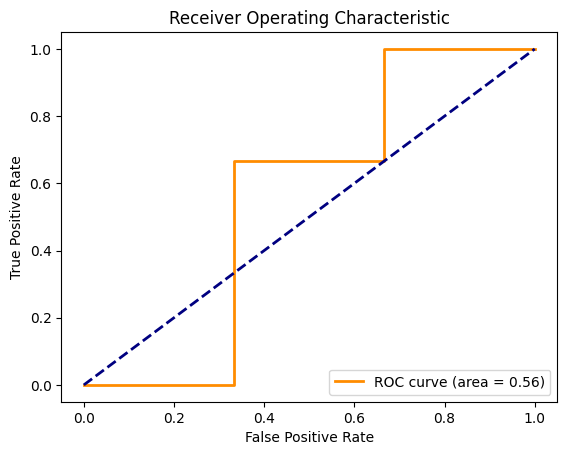

In [12]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(scores, labels):
    # Check if labels or scores are empty
    if labels.size == 0 or scores.size == 0:
        print("Error: Labels or scores are empty. Cannot plot ROC curve.")
        return  # Exit the function to avoid further errors

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Assuming labels are available (1 for genuine, 0 for imposter)
# Ensure labels are not empty and contain binary values (0 or 1)
labels = np.array([1, 0, 1, 0, 1, 0])  # Example labels - Replace with your actual labels

# Ensure match_scores_rbf is not empty
# Replace with your actual match_scores_rbf calculation
match_scores_rbf = np.random.rand(len(labels))

# Now call the plot_roc_curve function
plot_roc_curve(match_scores_rbf, labels)

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(scores, labels):
    # Check if labels or scores are empty
    if labels.size == 0 or scores.size == 0:
        print("Error: Labels or scores are empty. Cannot plot ROC curve.")
        return

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Calculate EER
    eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    print(f"Equal Error Rate (EER): {eer:.4f}")

    return eer

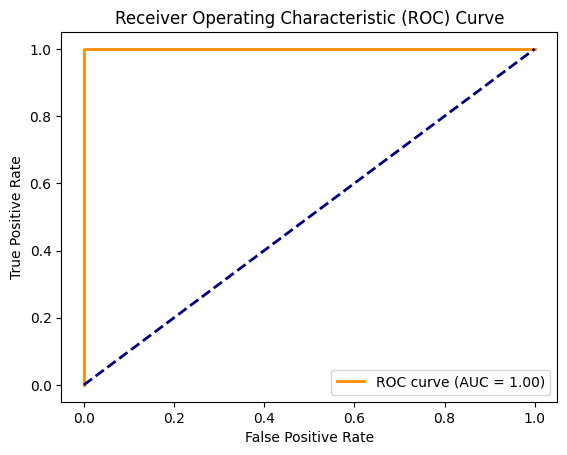

Equal Error Rate (EER): 0.0000


In [14]:
# Example match scores and labels
match_scores = np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
labels = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0])

# Plot ROC curve and calculate EER
eer = plot_roc_curve(match_scores, labels)

In [15]:
import numpy as np

def calculate_accuracy(scores, labels, threshold):
    # Classify predictions based on the threshold
    predictions = (scores >= threshold).astype(int)

    # Compare predictions with true labels
    correct_predictions = np.sum(predictions == labels)

    # Calculate accuracy
    accuracy = correct_predictions / len(labels)

    return accuracy

# Example match scores and labels
match_scores = np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
labels = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0])

# Define the threshold
threshold = 0.5

# Calculate accuracy
accuracy = calculate_accuracy(match_scores, labels, threshold)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.78%
